In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from custom_transform import OutlierCapper

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV,
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('dataset.csv')
df.sample(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
123,58,0,2,180,393,0,0,110,1,1.0,2,1
1113,47,1,4,112,204,0,0,143,0,0.1,1,0
501,65,1,4,136,248,0,0,140,1,4.0,3,1
1115,54,1,4,110,206,0,2,108,1,0.0,2,1
902,57,1,3,150,168,0,0,174,0,1.6,1,0


## Exploratory Data Analysis (EDA)

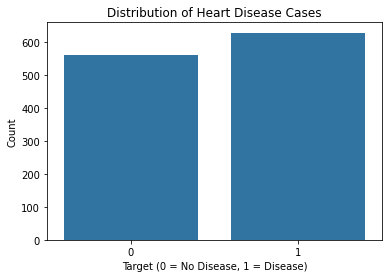

Class distribution:
target
1    52.857143
0    47.142857
Name: count, dtype: float64


In [ ]:
# Class Balance

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease Cases')
plt.xlabel('Target (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')
plt.show()

class_counts = df['target'].value_counts()
class_percent = class_counts / len(df) * 100
print(f"Class distribution:\n{class_percent}")

The dataset is nearly balanced, with only a slight majority in class 1.  
No major class imbalance,

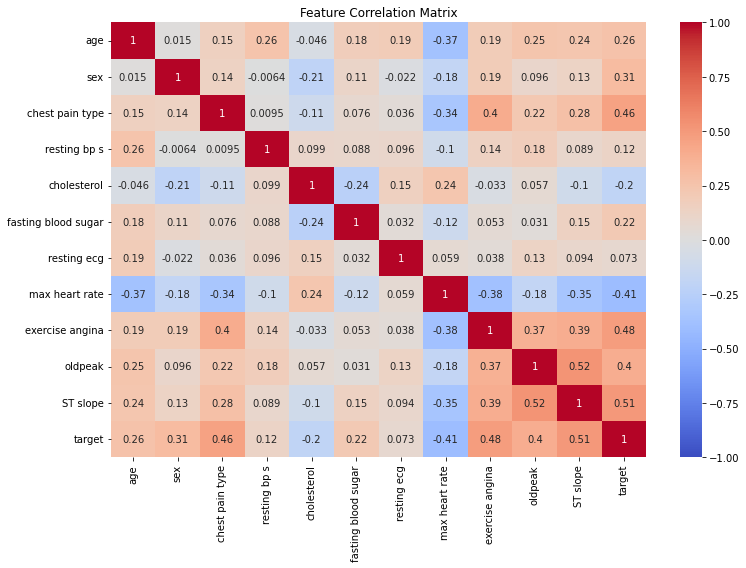


Correlation with target variable:
target                 1.000000
ST slope               0.505608
exercise angina        0.481467
chest pain type        0.460127
oldpeak                0.398385
sex                    0.311267
age                    0.262029
fasting blood sugar    0.216695
resting bp s           0.121415
resting ecg            0.073059
cholesterol           -0.198366
max heart rate        -0.413278
Name: target, dtype: float64


In [177]:
# correlation matrix

corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# correlations with target
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("\nCorrelation with target variable:")
print(target_corr)

<small>

-  `ST slope`, `exercise angina`, and `chest pain` type have the strongest positive correlation, suggesting they are good predictors.

- `Oldpeak`, `sex`, `age`, and `fasting blood sugar` show moderate positive correlation, indicating some predictive power.

- `Resting BP`, `resting ECG`, and `cholesterol` have weak correlations, implying limited impact.

- `Max heart rate` has a moderate negative correlation, meaning higher max heart rate is associated with a lower chance of the target event.

In [178]:
# Numerical features
num_features = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

In [179]:
df[num_features].describe()

,age,resting bp s,cholesterol,max heart rate,oldpeak
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,132.153782,210.363866,139.732773,0.922773
std,9.358203,18.368823,101.420489,25.517636,1.086337
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,188.000000,121.000000,0.000000
50%,54.000000,130.000000,229.000000,140.500000,0.600000
75%,60.000000,140.000000,269.750000,160.000000,1.600000
max,77.000000,200.000000,603.000000,202.000000,6.200000


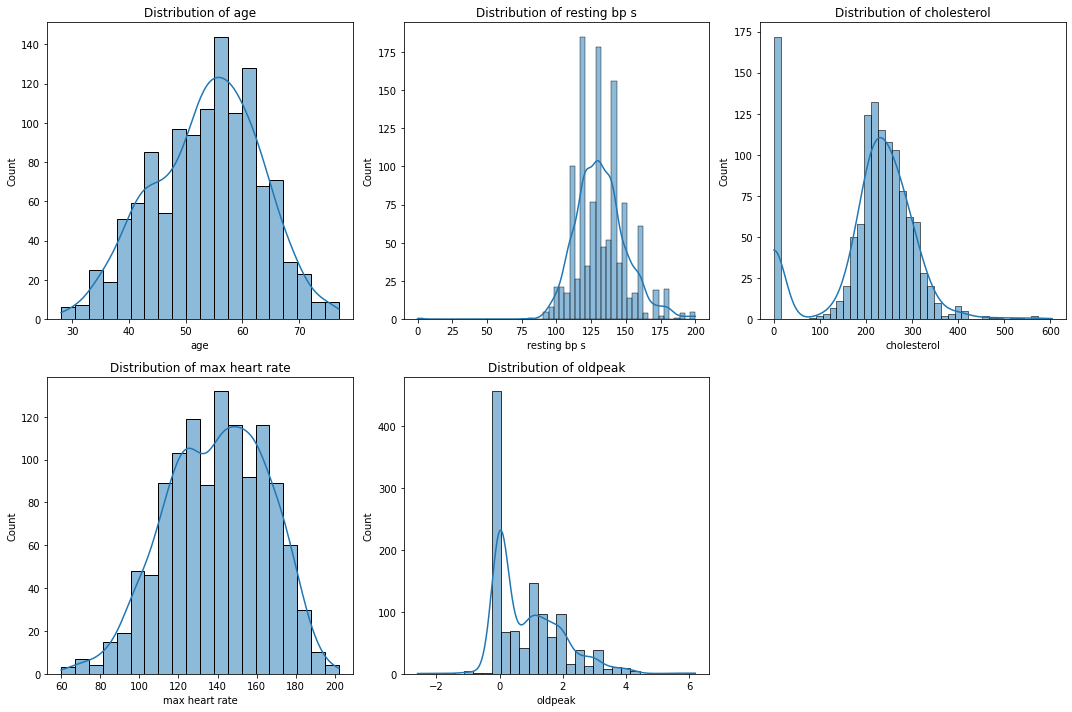

In [ ]:
# Numerical features distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

<small>

- `Age`: This distribution appears fairly symmetrical and bell-shaped, resembling a normal distribution.  

- `Resting BP (bps)`: This distribution is slightly right-skewed. Most values are concentrated between 100 and 150 bps, with a tail extending towards higher values.  

- `Cholesterol`: This distribution is also right-skewed. The majority of cholesterol levels are clustered on the lower end (around 200-300 mg/dL), with a long tail towards higher values. There's also a noticeable spike at the very beginning of the distribution, which might indicate a group with very low cholesterol or a data recording anomaly.  

- `Max Heart Rate`: This distribution looks approximately symmetrical and bell-shaped, similar to a normal distribution.  

- `Oldpeak`: This distribution is highly right-skewed. A large number of observations are concentrated at or near 0, with a long tail extending to positive values.

<small>

**So the features `Resting BP`, `Cholesterol`, `Oldpeak` requires Power Transform**

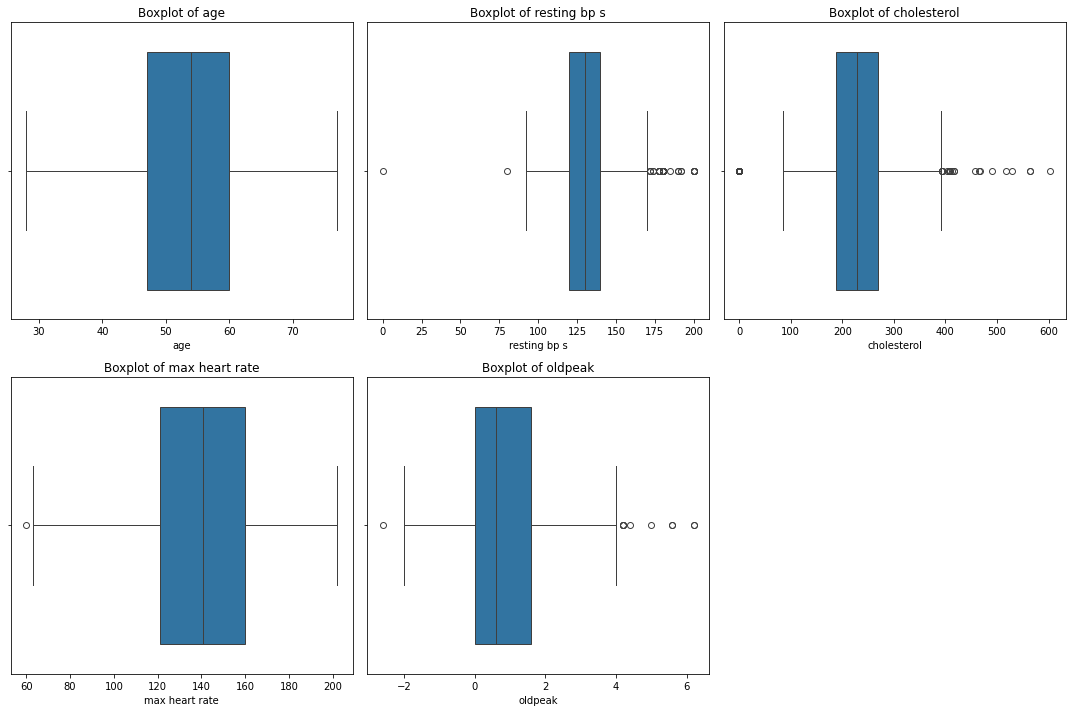

In [ ]:
# outliers detection
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

<small>

`Age`: Distribution is clean, no extreme values.  

`Resting BP`: Several high outliers (above ~150), one extreme low value (~0).  

`Cholesterol`: Many high outliers (above ~400), and one at 0 which might be invalid (cholesterol usually can't be 0).  

`Max Heart Rate`: A few outliers on the lower end (~60s), rest is clean.  

`Oldpeak`: Some high outliers (above ~4), and one negative outlier (could be suspicious depending on context).  

<small>

**So the features `Resting BP`, `Cholesterol`, `Oldpeak` requires Handeling Outliers**

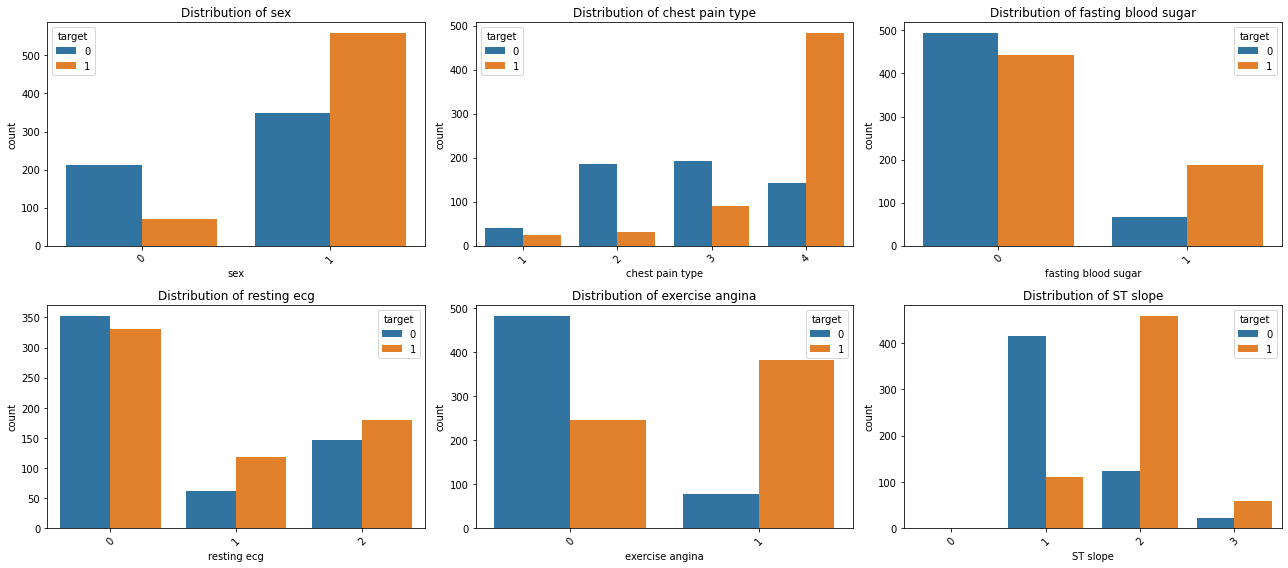


Value counts for sex:
1: 909 (76.39%)
0: 281 (23.61%)

Value counts for chest pain type:
4: 625 (52.52%)
3: 283 (23.78%)
2: 216 (18.15%)
1: 66 (5.55%)

Value counts for fasting blood sugar:
0: 936 (78.66%)
1: 254 (21.34%)

Value counts for resting ecg:
0: 684 (57.48%)
2: 325 (27.31%)
1: 181 (15.21%)

Value counts for exercise angina:
0: 729 (61.26%)
1: 461 (38.74%)

Value counts for ST slope:
2: 582 (48.91%)
1: 526 (44.20%)
3: 81 (6.81%)
0: 1 (0.08%)


In [ ]:
cat_features = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']

plt.figure(figsize=(18, 8))  
for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)  
    sns.countplot(x=feature, hue=df['target'], data=df)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

di = {}
for feature in cat_features:
    di[feature] = df[feature].value_counts().to_dict()
for feature, counts in di.items():
    print(f"\nValue counts for {feature}:")
    for value, count in counts.items():
        print(f"{value}: {count} ({(count / len(df)) * 100:.2f}%)")

<small>

`Sex`:  
Majority are 1 (likely male) at 76%, females 24%.
Dataset is male-dominated, so results might be more reflective of males.

`Chest Pain Type`:  
Most common type is 4 (52.5%), then 3 (23.8%), fewer cases with types 2 and 1.
Indicates some chest pain types are much more frequent; may reflect severity or common symptoms in the dataset.

`Fasting Blood Sugar`:  
Majority have normal fasting blood sugar 0 (79%), smaller group elevated 1 (21%).
Elevated fasting sugar is a risk factor; 1 in 5 has high sugar, which might correlate with heart issues.

`Resting ECG`:  
Mostly normal or mildly abnormal readings: 0 (57%), then 2 (27%), fewer 1 (15%).
Distribution suggests most patients have typical or borderline ECG results.

`Exercise Angina`:  
61% no angina, 39% have exercise-induced angina.
Almost 2 in 5 have angina triggered by exercise, an important clinical symptom.

`ST Slope`:  
Majority have slopes 2 (49%) or 1 (44%), very few 3 (7%) or 0 (0.1%).
ST slope is related to ischemia; high concentration in two categories might indicate typical ECG response patterns.

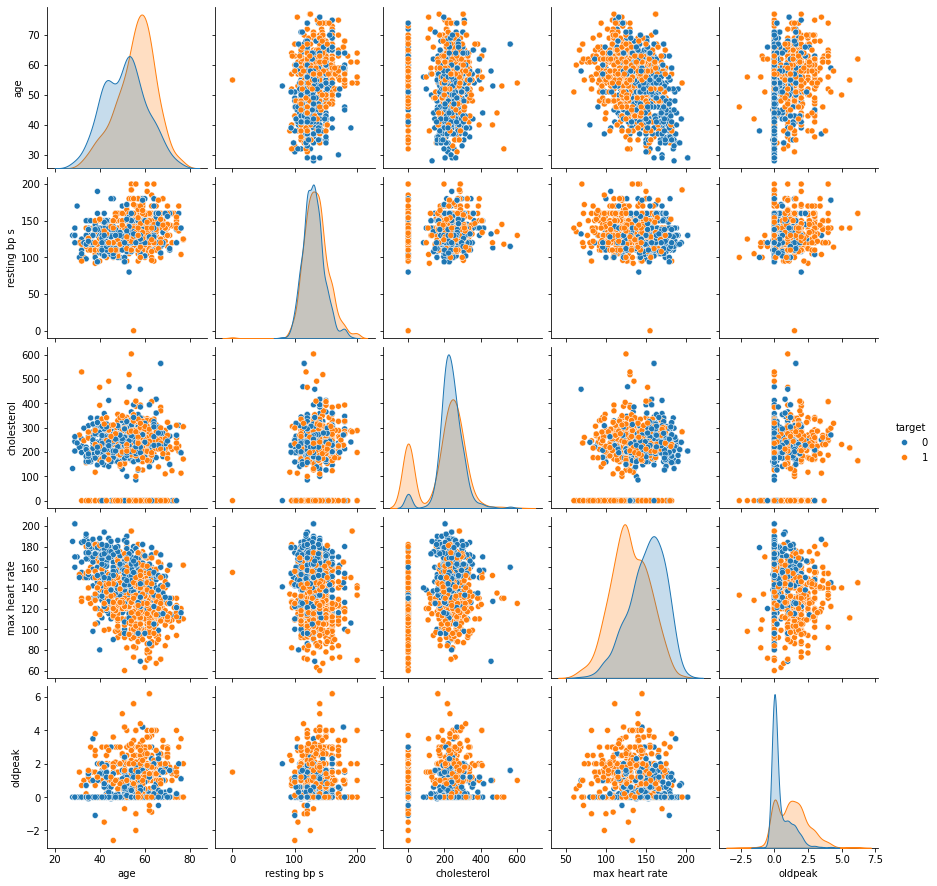

In [183]:
sns.pairplot(df[num_features + ['target']], hue='target')
plt.show()

## Data Preprocessing

In [ ]:
# Changing numerical columns dtype from int to float to avoid dtype incompatibility warnings
for col in num_features:
    df[col] = df[col].astype(float)

In [ ]:
# Handeling Outliers with IQR percentile method 
''' 
Here 'OutlierCapper' is a custom transformer that caps outliers based on the IQR method 
imported from custom_transform.py
'''
trf1 = ColumnTransformer([('outlier_handling',OutlierCapper(),[3, 4, 9])],remainder='passthrough')

In [ ]:
# Applying Power Transformer (Yeo-Johnson)
trf2 = ColumnTransformer([('power_transform', PowerTransformer(method='yeo-johnson'), [3, 4, 9])], remainder='passthrough')

In [ ]:
# Standardization
# numerical features : ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
trf3 = ColumnTransformer([('standard_scaler', StandardScaler(), [0, 3, 4, 7, 9])], remainder='passthrough')

In [ ]:
# Logistic Regression Model
trf4 = LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
    ('trf4',trf4),
])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['target']),df['target'],test_size=0.2,random_state=42)

In [191]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outlier_handling',
                                                  OutlierCapper(),
                                                  [3, 4, 9])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power_transform',
                                                  PowerTransformer(),
                                                  [3, 4, 9])])),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  [0, 3, 4, 7, 9])])),
                ('trf4', LogisticRegression(max_iter=1000, random_state=42))])

Accuracy: 0.8571428571428571
Precision: 0.8702290076335878
Recall: 0.8702290076335878
F1 Score: 0.8702290076335878


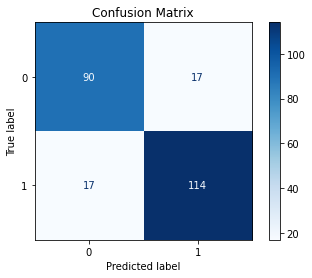

In [192]:
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

In [ ]:
params = {
    'trf4__penalty': ['l1', 'l2'],
    'trf4__C': [0.1, 1, 10],
    'trf4__solver': ['liblinear', 'saga'],
    'trf4__class_weight': [None, 'balanced'],
}

grid_search = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('outlier_handling',
                                                                         OutlierCapper(),
                                                                         [3, 4,
                                                                          9])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('power_transform',
                                                                         PowerTransformer(),
                                                                         [3, 4,
                                                                          9])])),
                                       ('trf3',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         [0, 3,
                                                                          4, 7,
                                                                          9])])),
                                       ('trf4',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'trf4__C': [0.1, 1, 10],
                         'trf4__class_weight': [None, 'balanced'],
                         'trf4__penalty': ['l1', 'l2'],
                         'trf4__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [194]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters: {'trf4__C': 1, 'trf4__class_weight': 'balanced', 'trf4__penalty': 'l2', 'trf4__solver': 'saga'}


In [195]:
y_pred = best_model.predict(X_test)

Accuracy: 0.8487394957983193
Precision: 0.8682170542635659
Recall: 0.8549618320610687
F1 Score: 0.8615384615384616


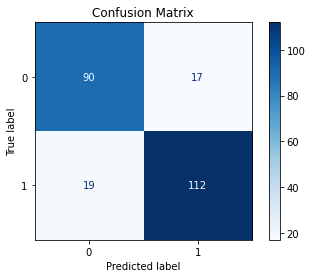

In [ ]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Hence getting accuracy of around 85%.

## Saving Trained Model

In [197]:
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)